In [27]:
import caiman as cm
import glob
import gc
import numpy as np
import matplotlib.pyplot as plt
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from pathlib import Path
import pickle
import mesmerize_core as ms

import logreader.logreader as lr
import pipeline.functions as fs



# Session overview
Use this notebook to load and inspect the raw tif video, preprocess it with a set of parameters and asses their effectiveness.

## select session

In [28]:
# chose session
animal = '441394_ribolla'
date = '20230301'
animal_num = animal.split('_')[0]

raw_data_path = Path("/ceph/imaging1/arie")
data_path = raw_data_path.joinpath(f'{animal}/{date}_{animal_num}')
temp_output_path = Path('/scratch/dspalla/2p_data')


# Interactive visualization of the raw video
This requires to load the video to memory, and can be slow.

In [29]:
tif_file = glob.glob(str(data_path)+'/*.tif')[0]
movie = cm.load(tif_file)

In [ ]:
# make an image widget
from fastplotlib import ImageWidget, Plot, GridPlot
from ipywidgets import VBox, IntSlider, Layout

movies = [movie]

iw = ImageWidget(
    movies, 
    window_funcs={"t": (np.mean, 100)},
    vmin_vmax_sliders=True,
    cmap="jet"
)

iw.show()

# Preprocess session
Full pipeline preprocessing for a single session. All data (temporary and final outputs) is saved to the temp folder.

In [64]:
# PREPROCESSING STEPS
preprocess_vr_data = False
preprocess_2p_video = True

In [72]:
# PARAMETERS
compute_flags = {'correct_luminance':True,
                 'refit_cnmf':True,
                 'deconvolve' :True,
                 'detrend_df_f': True,
                 'n_processes': 5 #number of parallel processes.
                }

cropping_params = {'cropping_limits': [10,-10, 10,-10],
                   'cropping_times':[0,10000]}

mc_params = {# Caiman parameters
             'max_shifts': [20, 20],  #maximum allowed rigid shifts (in pixels)
             'num_frames_split':300,
             'strides': [48, 48], # start a new patch for pw-rigid motion correction every x pixels
             'overlaps': [24, 24], # overlap between pathes (size of patch strides+overlaps)
             'max_deviation_rigid': 5,  # maximum allowed shifts from rigid template (in pixels)
             'border_nan': 'copy',
             'pw_rigid': True, # flag for performing non-rigid motion correction
             'use_cuda': True,
             'gSig_filt': [6,6]}

# metrics to compute on motion corrected video
metrics_params = ['mean_image','frame_average','corr_image']

cnmf_params  = {'fr': 30, # framerate of the video, very important!
                'p': 1,   # order of autoregressive process contstraint
                'nb': 2,  # number of backround components       
                'merge_thr': 0.85, # correlation th to merge to sources
                'rf': 20,    # half-size of patch in pixels
                'stride': 12, # "overlap between patches in pixels, should be roughly neuron diameter
                'K': 6,      # number of neurons per pathc
                'gSig': [6, 6], # half-size of neuron in pixels (row,columns)
                'ssub': 1, # spatial compression, if larger than one compresses
                'tsub': 1, # temporal compression, if larger than one compresses
                'method_init': 'greedy_roi',
                'min_SNR': 2.5,  # min snr for good components, used in an OR rule with min_cnn_thr and rval_thr
                 #'min_SNR_reject': 3.0, # min snr for good components, used in an AND rule with min_cnn_lowest and r_values_lowest
                'rval_thr': 0.95, # spatial footprint consistency
                'use_cnn': True,
                'min_cnn_thr': 0.9,
                #'cnn_lowest': 0.9,
                'decay_time': 0.4,
                }
df_f_params = {'quantileMin':8,
               'frames_window':250       
                }

parameters = {'compute_flags': compute_flags,
              'cropping_params':cropping_params,
              'mc_params': mc_params,
              'metrics_params':metrics_params,
              'cnmf_params': cnmf_params,
              'df_f_params':df_f_params
                }

log file: /ceph/imaging1/arie/441394_ribolla/20230301_441394/20230301-122835_051.b64
tif file: /ceph/imaging1/arie/441394_ribolla/20230301_441394/20230301_441394_00001.tif
Cropping movie ...
Correcting luminance fluctuations
Motion-correcting movie ...
Starting CaImAn server
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/cropped_d1_492_d2_492_d3_1_order_F_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/cropped_d1_492_d2_492_d3_1_order_F_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/cropped_d1_492_d2_492_d3_1_order_F_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/cropped_d1_492_d2_492_d3_1_order_F_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/cropped_d1_492_d2_492_d3_1_order_F_frames_8496.mmapDecode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/cropped_d1_492_d2_492_d3_1_order_F_frames_849

Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap


Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap


Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap


Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap


Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap


Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap


Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap


Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_C_frames_8496.mmap
GPU run not requested, disabling use of GPUs
USING MODEL (keras API): /home/dspalla/caiman_data/model/cnn_model.json
52/52 [==============================] - 1s 18ms/step
Deconvolve components
Extract df/f
Savign CNMF object in hdf5
Saving neural data for downstream analysis @/scratch/dspalla/2p_data/441394_ribolla/20230301
Done


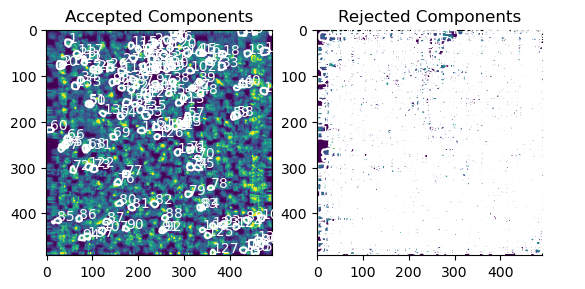

In [73]:
session_path = raw_data_path.joinpath(f'{animal}/{date}_{animal_num}')
        
tif_file = glob.glob(str(session_path)+'/*.tif')[0]
log_file = glob.glob(str(session_path)+'/*.b64')[0]
        
        
print(f'log file: {log_file}')
print(f'tif file: {tif_file}')

#make temp dir
temp_path = temp_output_path.joinpath(f'{animal}/{date}')
Path(temp_path).mkdir(parents=True, exist_ok=True)


#Decode log and process behaviour
if preprocess_vr_data:
    try:
        vr_data = lr.preprocess_vr_data(tif_file = tif_file, log_file=log_file)
        lr.save_processed_vr_data(temp_path,vr_data)
    except:
        print(f'Error in session {animal}_{date}, skipping ...')

#Run caiman pipeline 
if preprocess_2p_video:
    fs.preprocess_video(input_video=tif_file,
                    output_folder=temp_path,
                    parameters=parameters,
                    temp_folder=temp_path,
                    keep_temp_folder = True)
        
        
        

# Visualize preprocessed session

## Summary images and metrics

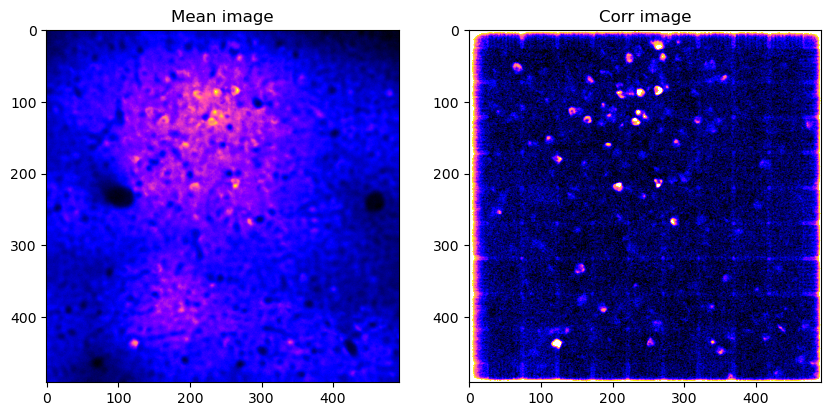

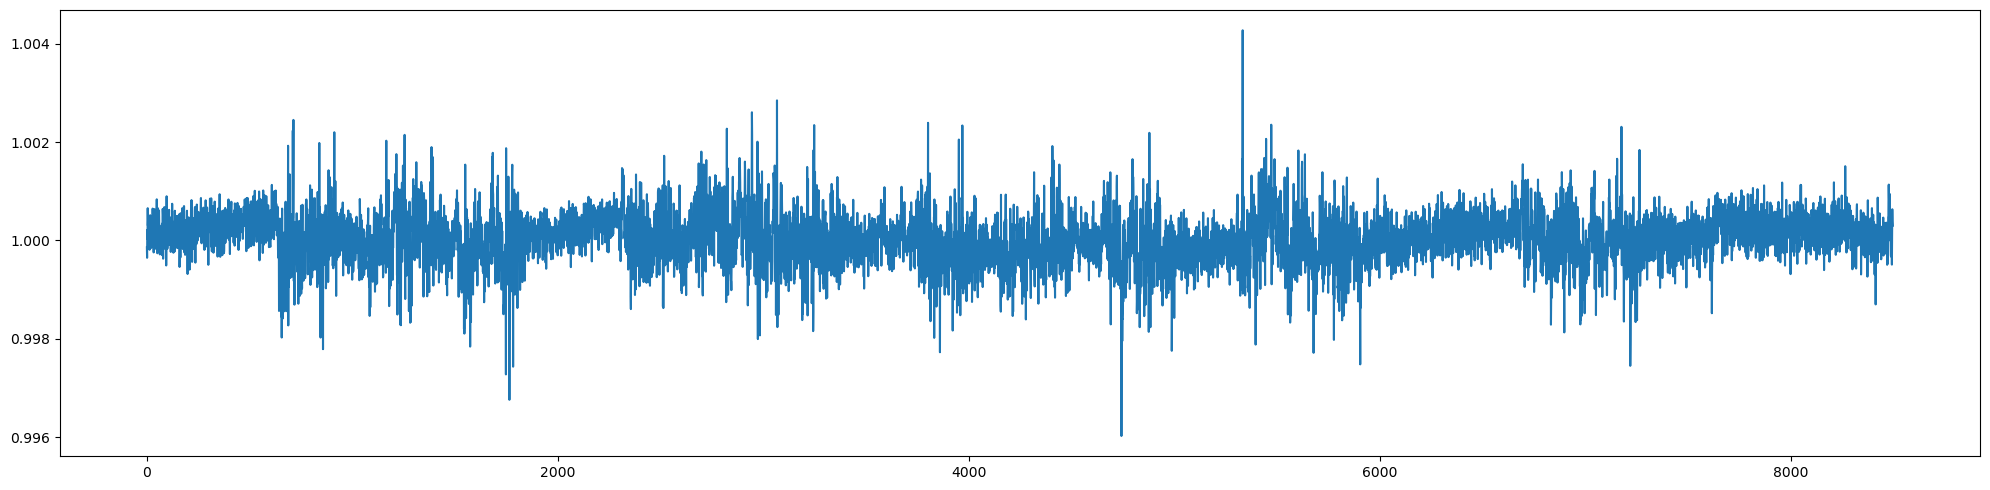

In [74]:
metrics_file = temp_path.joinpath('metrics.pickle')
with open(metrics_file,'rb') as file:
    metrics = pickle.load(file)


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Mean image')
plt.imshow(metrics['mean_image'],cmap=plt.cm.gnuplot2)

plt.subplot(1,2,2)
plt.title('Corr image')
x = metrics['corr_image']
plt.imshow(x,vmin=np.percentile(x.ravel(),3),vmax=np.percentile(x.ravel(),97),
           cmap=plt.cm.gnuplot2)

plt.figure(figsize=(20,5))
plt.plot(metrics['frame_average'])
#plt.ylim([0.9,1.1])


plt.tight_layout()

## Interactive video

In [75]:
cropped_file = glob.glob(str(temp_path)+'/cropped*.mmap')[0]
mcorr_file = glob.glob(str(temp_path)+'/mcorr*.mmap')[0]
#print(tif_file)
print(cropped_file)
print(mcorr_file)

/scratch/dspalla/2p_data/441394_ribolla/20230301/cropped_d1_492_d2_492_d3_1_order_F_frames_8496.mmap
/scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_F_frames_8496.mmap


In [76]:
cropped_movie = cm.load(cropped_file)
mcorr_movie = cm.load(mcorr_file)

# make an image widget
from fastplotlib import ImageWidget, Plot, GridPlot
from ipywidgets import VBox, IntSlider, Layout

movies = [cropped_movie,mcorr_movie]

iw = ImageWidget(
    movies, 
    window_funcs={"t": (np.mean, 100)},
    vmin_vmax_sliders=True,
    cmap="jet"
)

iw.show()


Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/cropped_d1_492_d2_492_d3_1_order_F_frames_8496.mmap
Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_F_frames_8496.mmap


RFBOutputContext()

In [77]:
iw.plot.canvas.close()

# Extractred compontents 

In [78]:
cnmf_file = temp_path.joinpath('cnmf.hdf5')
cnmf = load_CNMF(cnmf_file)
ests = cnmf.estimates

print(f'total # of components:{len(ests.idx_components)+len(ests.idx_components_bad)}')
print(f'GOOD components:{len(ests.idx_components)}')
print(f'BAD components:{len(ests.idx_components_bad)}')

total # of components:1660
GOOD components:138
BAD components:1522


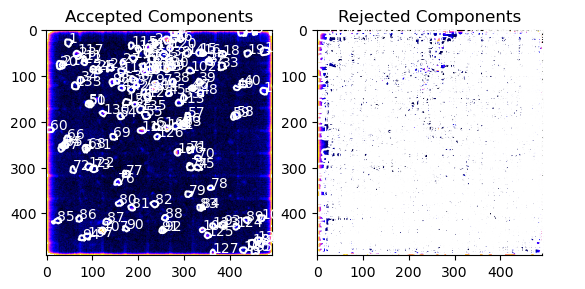

In [79]:
ests.plot_contours(img=np.asarray(metrics['corr_image']),idx=ests.idx_components,cmap=plt.cm.gnuplot2)

### Plot timecourses and footprints examples

In [37]:
from ipywidgets import interact
import ipywidgets as widgets

def plot_unit(i,min_time,max_time):
    
    good_traces = ests.C[ests.idx_components]
    good_footprints = ests.A[:,ests.idx_components].toarray()

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(f'neuron {i}')
    plt.imshow(good_footprints[:,i].reshape(ests.dims),cmap=plt.cm.gnuplot2)
    
    plt.subplot(1,2,2)
    plt.plot(np.arange(min_time,max_time),good_traces[i,min_time:max_time])
    
    
    plt.tight_layout()
    
    
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(len(ests.idx_components)-1), value=0),
                    min_time =widgets.IntSlider(min=0, max=ests.C.shape[1]-1, value=0),
                    max_time = widgets.IntSlider(min=0, max=ests.C.shape[1]-1, value=10000)
         )

interactive(children=(IntSlider(value=0, description='i', max=138), IntSlider(value=0, description='min_time',…

<function __main__.plot_unit(i, min_time, max_time)>

### Make and display reconstructed video

In [80]:
# memory intensive
movie_len = 1000
r_mov = ests.A[:,ests.idx_components]@ests.C[ests.idx_components,:movie_len]
r_mov = r_mov.reshape(ests.dims + (-1,), order='F')
r_mov = np.transpose(r_mov,(2,0,1))

In [81]:
r_mov.shape

(1000, 492, 492)

In [82]:
mcorr_file = glob.glob(str(temp_path)+'/mcorr*.mmap')[0]
mcorr_movie = cm.load(mcorr_file)[:movie_len]

Decode mmap filename /scratch/dspalla/2p_data/441394_ribolla/20230301/mcorr_d1_492_d2_492_d3_1_order_F_frames_8496.mmap


In [83]:
from fastplotlib import ImageWidget, Plot, GridPlot
from ipywidgets import VBox, IntSlider, Layout

iw = ImageWidget(
    [mcorr_movie,r_mov], 
    window_funcs={"t": (np.mean, 10)},
    vmin_vmax_sliders=True,
    cmap='jet'
)



iw.show()


RFBOutputContext()

In [ ]:
iw.plot.canvas.close()

# Component quality distribution

### SNR and CNN confidence distributions

Text(0.5, 0, 'cnn confidence')

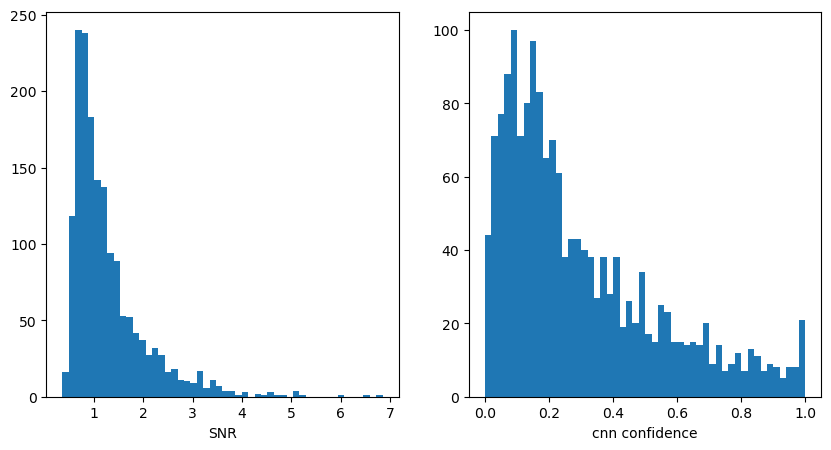

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(ests.SNR_comp,bins=50);
plt.xlabel('SNR')
plt.subplot(1,2,2)
plt.hist(ests.cnn_preds,bins=50);
plt.xlabel('cnn confidence')

### Sensitivity analysis
Plots the number of components accepted as good for varyig thresholds

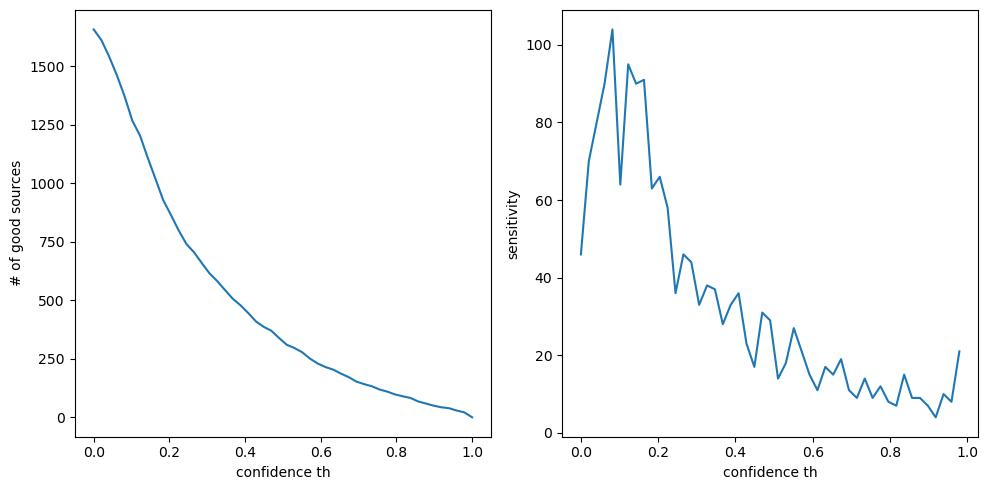

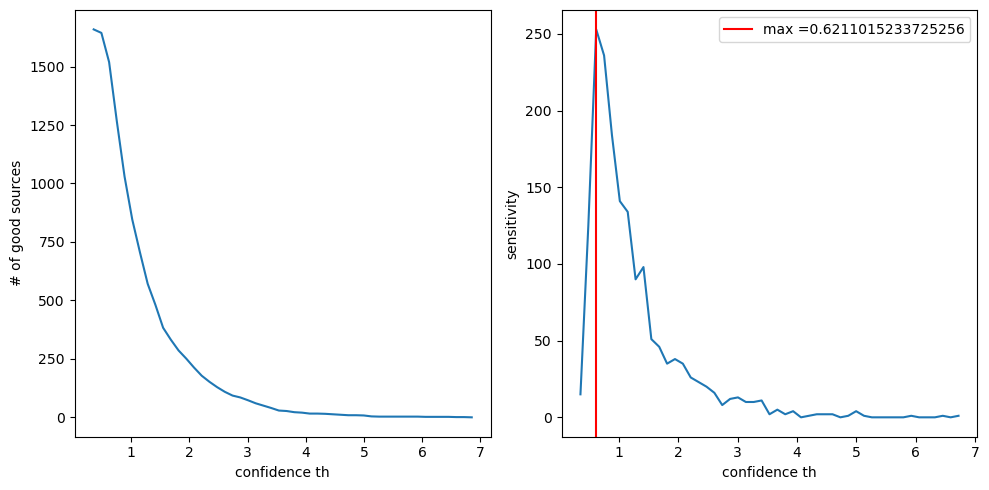

In [26]:
ths_cnn = np.linspace(0,1)
ths_snr = np.linspace(min(ests.SNR_comp),max(ests.SNR_comp))


good_sources_cnn = []
good_sources_snr = []

for th_cnn,th_snr in zip(ths_cnn,ths_snr):
    good_sources_cnn.append(np.sum(ests.cnn_preds>th_cnn))
    good_sources_snr.append(np.sum(ests.SNR_comp>th_snr))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ths_cnn,good_sources_cnn)
plt.xlabel('confidence th')
plt.ylabel('# of good sources')
plt.subplot(1,2,2)
plt.plot(ths_cnn[:-1],abs(np.diff(good_sources_cnn)))
plt.xlabel('confidence th')
plt.ylabel('sensitivity')
plt.tight_layout()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ths_snr,good_sources_snr)
plt.xlabel('confidence th')
plt.ylabel('# of good sources')
plt.subplot(1,2,2)
plt.plot(ths_snr[:-1],abs(np.diff(good_sources_snr)))
max_sens = ths_snr[np.argmax(abs(np.diff(good_sources_snr)))]
plt.axvline(x=max_sens,label=f'max ={max_sens}',c='r')
plt.legend()
plt.xlabel('confidence th')
plt.ylabel('sensitivity')
plt.tight_layout()

# Save session parameters
Save preprocessing parameters in the folder preprocessing_params in the raw data path. These parameters will be read by the batch preprocesser when iterating over session together. When no parameters are found for a session, the default (stored in default_parameters) will be used.

In [86]:
 ## save parameters
import yaml 
    
# redefine corpping for whole video
cropping_params = {'cropping_limits': [10,-10, 10,-10],
                   'cropping_times':[0,-1]}

parameters['cropping_params'] = cropping_params
    
        
with open(Path(raw_data_path).joinpath(f'preprocess_params/parameters_{animal}_{date}.yml'),'w') as file:
    yaml.dump(parameters,file)

In [87]:
with open(Path(raw_data_path).joinpath(f'preprocess_params/default_parameters.yml'),'w') as file:
    yaml.dump(parameters,file)

# clean temp directory
delete the temporary directory to free disk space

In [ ]:
/ceph/imaging1/arie/preprocess_params